# Plot for Retune 2025 Conference

In [1]:
# Load and plot the 12 time series in the first entry of dataframe_lfp
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:

with open('dataframe_lfp.pkl', 'rb') as f:
    df = pickle.load(f)

first_lfp = np.array(df['lfp_data'][0])
print('Shape of first lfp_data entry:', first_lfp.shape)

# Inspect the type and keys/shape
print('Type:', type(df))
if isinstance(df, dict):
    print('Keys:', df.keys())
elif isinstance(df, np.ndarray):
    print('Shape:', df.shape)
elif isinstance(df, pd.DataFrame):
    print('Columns:', df.columns)
else:
    print('Unknown structure:', df)

Shape of first lfp_data entry: (149999, 12)
Type: <class 'pandas.core.frame.DataFrame'>
Columns: Index(['acronym', 'lfp_data', 'overlapping_acronyms'], dtype='object')


In [3]:
def plot_lfp_seconds(lfp, region_labels=None, sfreq=2500, title=None, figsize=(20, 10),
                     fontsize=12, legend_loc='upper right', save_name=None): 
    """
    Plot multichannel LFP time series with x-axis in seconds.
    - lfp: array-like, shape either (n_channels, n_samples) or (n_samples, n_channels)
    - region_labels: list/array of channel names (length n_channels)
    - sfreq: sampling frequency in Hz (default 2500)
    - save_name: optional string filename to save the figure (e.g. 'plot.png'); default None (no save)
    """
    if save_name is not None and not isinstance(save_name, str):
        raise TypeError("save_name must be a string filename or None")

    lfp = np.array(lfp)
    if lfp.ndim == 1:
        # single channel vector: make it (n_samples, 1)
        lfp = lfp[:, None]

    # If rows correspond to channels, transpose to shape (n_samples, n_channels)
    if region_labels is not None and lfp.shape[0] == len(region_labels) and lfp.shape[1] != len(region_labels):
        lfp = lfp.T
    elif region_labels is None and lfp.shape[0] < lfp.shape[1]:
        # heuristic: if fewer rows than columns, assume rows are channels -> transpose
        lfp = lfp.T

    n_time, n_channels = lfp.shape
    time = np.arange(n_time) / float(sfreq)

    plt.figure(figsize=figsize)
    for ch in range(n_channels):
        label = (region_labels[ch] if region_labels is not None and ch < len(region_labels) else None)
        plt.plot(time, lfp[:, ch], label=label)

    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    if title:
        plt.title(title)
    if region_labels is not None:
        plt.legend(loc=legend_loc, fontsize=fontsize, bbox_to_anchor=(1, 1))
    plt.tight_layout()

    if save_name:
        plt.savefig(save_name, dpi=300, bbox_inches='tight')

    plt.show()
    return plt.gcf()


In [4]:
def compute_and_plot_fcd(entry_idx, df, sfreq=2500, win_sec=5, step_sec=1,
                         min_win_sec=0.5, cmap='plasma', symmetric_scale=False,
                         save_name=None, verbose=True):
    """
    Compute sliding-window FC and plot the Functional Connectivity Dynamics (FCD) heatmap.

    Parameters
    - entry_idx: int, index into df['lfp_data'] and df['acronym'] (0-based)
    - df: dataframe/dict-like object containing 'lfp_data' and 'acronym'
    - sfreq: sampling frequency in Hz
    - win_sec: desired window length in seconds
    - step_sec: sliding step in seconds
    - min_win_sec: minimum allowed window (seconds) when auto-adjusting
    - cmap: matplotlib colormap name for the heatmap
    - symmetric_scale: if True, scale colorbar symmetrically around 0 using max(abs(min),abs(max))
    - save_name: optional filename (string) to save the figure as PNG (dpi=300). If provided without extension, '.png' will be appended.
    - verbose: if True, print diagnostics

    Returns a dict with keys: fcd_matrix, time_axis, fc_windows, win_centers_sec, vmin, vmax
    """
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import zscore
    from scipy.interpolate import interp1d

    # params -> samples
    window_size = int(win_sec * sfreq)
    step_size = int(step_sec * sfreq)
    min_window_samples = int(min_win_sec * sfreq)

    # load
    lfp = np.array(df['lfp_data'][entry_idx])
    region_labels = df['acronym'][entry_idx] if isinstance(df['acronym'][entry_idx], (list, tuple, np.ndarray)) else [df['acronym'][entry_idx]]

    # ensure orientation: want (n_channels, n_samples)
    if lfp.ndim == 1:
        lfp = lfp[None, :]
    if lfp.shape[0] == len(region_labels) and lfp.shape[1] != len(region_labels):
        # rows are channels -> keep
        pass
    elif lfp.shape[1] == len(region_labels) and lfp.shape[0] != len(region_labels):
        lfp = lfp.T
    else:
        if lfp.shape[0] > lfp.shape[1]:
            pass
        else:
            lfp = lfp.T

    n_channels, n_samples = lfp.shape
    if verbose:
        print(f'Entry {entry_idx}: LFP shape (channels x samples): {n_channels} x {n_samples}')
        expected = sfreq * 60
        print(f'Expected samples for 60s at {sfreq} Hz: {expected} (actual: {n_samples})')

    # NaN handling: report then attempt interpolation per channel
    nan_counts = np.isnan(lfp).sum(axis=1)
    if verbose:
        print('NaN counts per channel (first 10):', nan_counts[:10])
    if nan_counts.max() > 0:
        if verbose:
            print('Attempting simple 1D interpolation for channels with NaNs...')
        for ch in range(n_channels):
            ch_data = lfp[ch].astype(float)
            if np.isnan(ch_data).any():
                good = ~np.isnan(ch_data)
                if good.sum() < 2:
                    # not enough points to interpolate
                    continue
                f = interp1d(np.where(good)[0], ch_data[good], kind='linear', bounds_error=False, fill_value='extrapolate')
                lfp[ch] = f(np.arange(n_samples))
        nan_counts_after = np.isnan(lfp).sum(axis=1)
        if verbose:
            print('NaN counts after interpolation (first 10):', nan_counts_after[:10])

    # adjust window if needed
    if window_size > n_samples:
        if verbose:
            print(f'Warning: requested window_size={window_size} > n_samples={n_samples}. Adjusting window size.')
        window_size = max(min_window_samples, n_samples // 2)
        step_size = max(1, min(step_size, window_size // 2))
        if verbose:
            print(f'New window_size={window_size} samples ({window_size/sfreq:.3f}s), step_size={step_size} samples ({step_size/sfreq:.3f}s)')

    # sliding windows
    fc_windows = []
    win_centers_sec = []
    for start in range(0, n_samples - window_size + 1, step_size):
        stop = start + window_size
        win = lfp[:, start:stop]  # (n_channels, window_size)
        with np.errstate(invalid='ignore'):
            win_z = zscore(win, axis=1, ddof=0)
        if np.isnan(win_z).any():
            continue
        if np.isfinite(win_z).sum() == 0:
            continue
        try:
            fc = np.corrcoef(win_z)
        except Exception:
            continue
        fc_windows.append(fc)
        win_centers_sec.append((start + stop) / 2.0 / sfreq)

    fc_windows = np.array(fc_windows)
    n_windows = fc_windows.shape[0] if fc_windows.size else 0
    if verbose:
        print(f'Computed {n_windows} FC windows')

    if n_windows == 0:
        if verbose:
            print('No valid windows for FCD. Suggestions: reduce win_sec or step_sec, or check for channels with constant values / many NaNs.')
        return dict(fcd_matrix=None, time_axis=None, fc_windows=fc_windows, win_centers_sec=win_centers_sec, vmin=None, vmax=None)

    # vectorize upper triangle
    triu_idx = np.triu_indices(n_channels, k=1)
    fc_vecs = np.array([fw[triu_idx] for fw in fc_windows])

    if fc_vecs.shape[0] == 1:
        fcd_matrix = np.array([[1.0]])
        time_axis = np.array(win_centers_sec)
    else:
        with np.errstate(invalid='ignore'):
            fcd_matrix = np.corrcoef(fc_vecs)
        time_axis = np.array(win_centers_sec)

    # color scale
    vmin = np.nanmin(fcd_matrix)
    vmax = np.nanmax(fcd_matrix)
    if not np.isfinite(vmin) or not np.isfinite(vmax):
        vmin, vmax = -1.0, 1.0
    elif np.isclose(vmin, vmax):
        eps = max(1e-6, abs(vmin) * 1e-3)
        vmin -= eps
        vmax += eps
    if symmetric_scale:
        m = max(abs(vmin), abs(vmax))
        vmin, vmax = -m, m

    # plot
    fig, ax = plt.subplots(figsize=(8, 6))
    extent = [time_axis[0], time_axis[-1], time_axis[0], time_axis[-1]]
    im = ax.imshow(fcd_matrix, cmap=cmap, vmin=vmin, vmax=vmax, origin='lower', extent=extent, aspect='auto')
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('FC similarity (Pearson r)')
    ax.set_xlabel('Window center time (s)')
    ax.set_ylabel('Window center time (s)')
    # invert y-axis so time 0 is at the top (upper-left corner of the heatmap)
    ax.invert_yaxis()
    ax.set_title(f'FCD gridplot (entry {entry_idx}) — win={win_sec}s step={step_sec}s — n_windows={n_windows}\n(vmin={vmin:.3g}, vmax={vmax:.3g})')
    plt.tight_layout()

    # save if requested
    if save_name is not None:
        if not isinstance(save_name, str):
            raise TypeError('save_name must be a string filename or None')
        fname = save_name if os.path.splitext(save_name)[1].lower() == '.png' else save_name + '.png'
        fig.savefig(fname, dpi=300, bbox_inches='tight')
        if verbose:
            print(f'Saved FCD figure to {fname}')

    if show := True:
        plt.show()

    return dict(fcd_matrix=fcd_matrix, time_axis=time_axis, fc_windows=fc_windows, win_centers_sec=win_centers_sec, vmin=vmin, vmax=vmax)


# Example usage (uncomment to run):
# res = compute_and_plot_fcd(4, df)   # entry 5
# res = compute_and_plot_fcd(9, df)   # entry 10
# res = compute_and_plot_fcd(21, df)  # entry 22
# To change window/step: compute_and_plot_fcd(4, df, win_sec=3, step_sec=0.5, symmetric_scale=True)


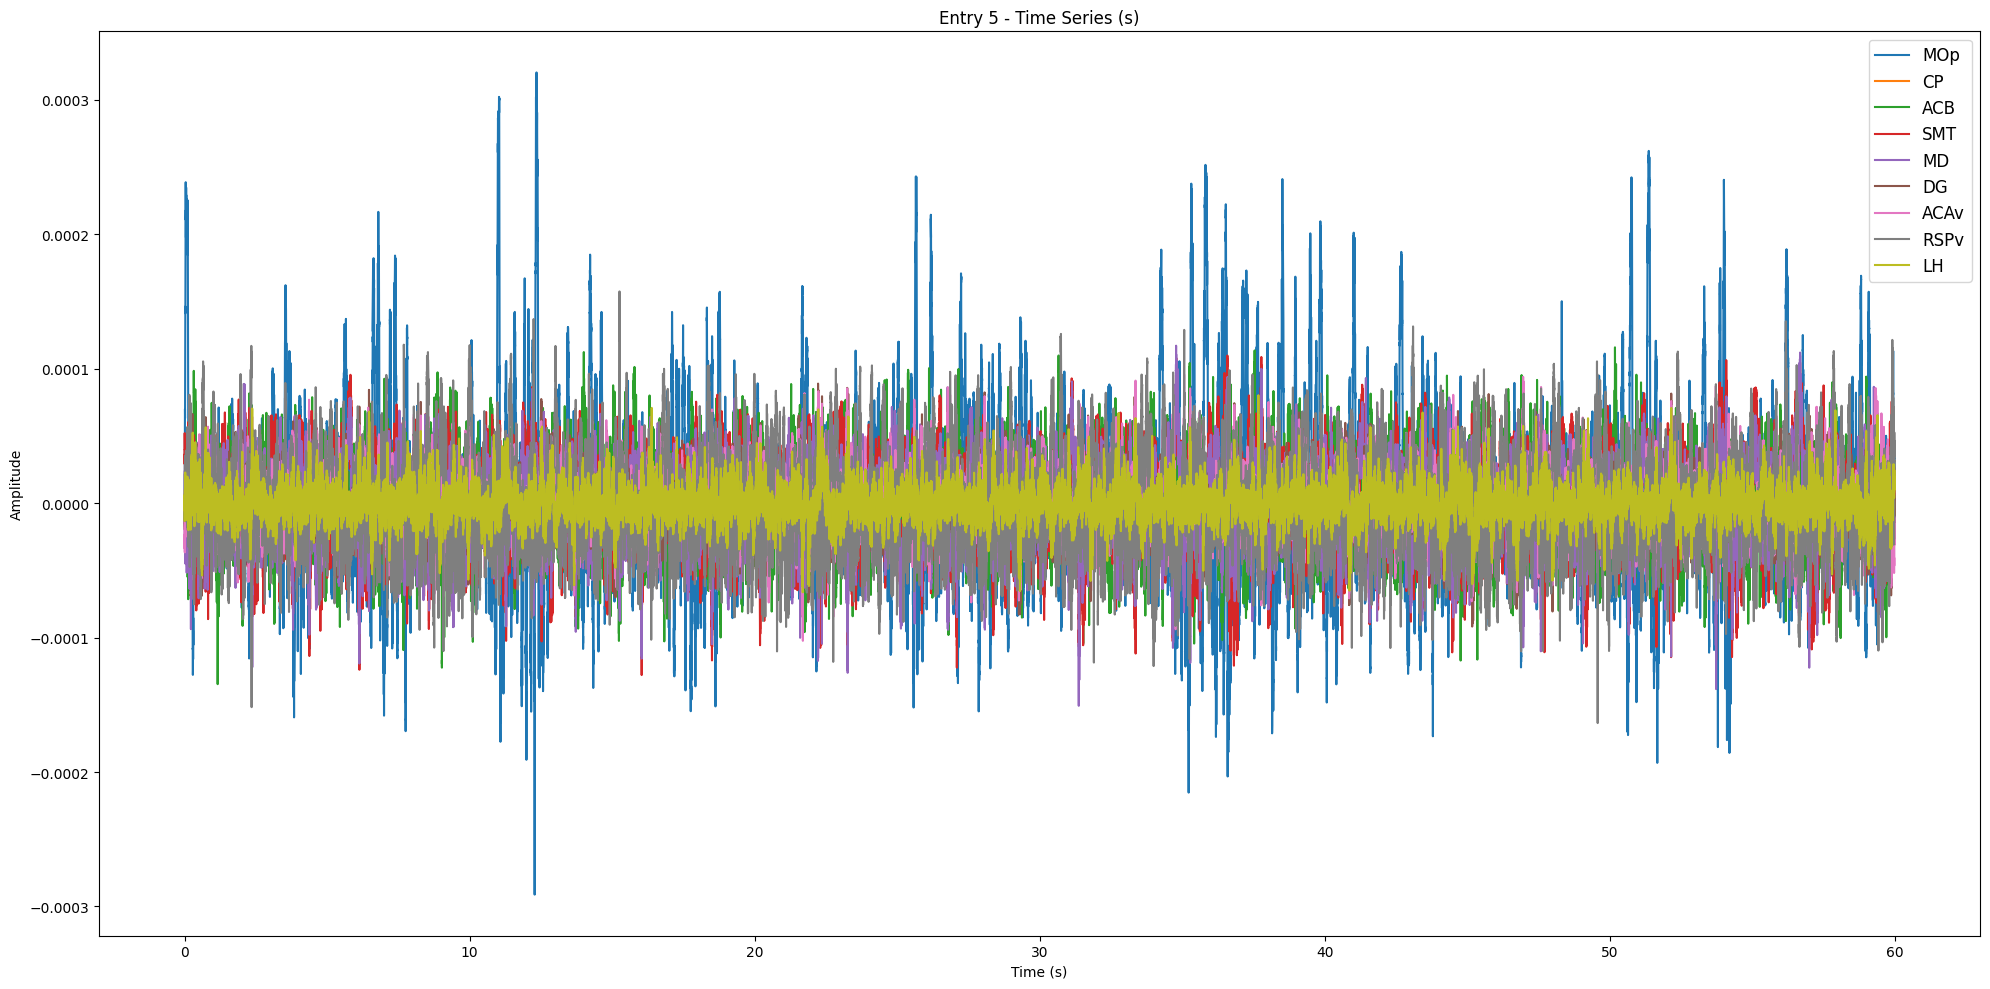

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [5]:
# Entry 5 (fifth_lfp / region_labels_5)
# Plot the time series for the fifth entry using its region labels
fifth_lfp = np.array(df['lfp_data'][4])
region_labels_5 = df['acronym'][4] if isinstance(df['acronym'][4], (list, tuple, np.ndarray)) else [df['acronym'][4]]

#plot_lfp_seconds(fifth_lfp, region_labels=region_labels_5, sfreq=2500, title='Entry 5 - Time Series (s)', save_name="Fifth_lfp_time_series.png")
plot_lfp_seconds(fifth_lfp, region_labels=region_labels_5, sfreq=2500, title='Entry 5 - Time Series (s)')

FC matrix shape: (9, 9)


,MOp,CP,ACB,SMT,MD,DG,ACAv,RSPv,LH
MOp,1.000000,-0.715626,-0.453212,0.053747,-0.022298,-0.019433,0.036667,0.099118,-0.092223
CP,-0.715626,1.000000,0.591388,-0.052112,0.003218,0.048147,-0.034538,-0.125000,0.120895
ACB,-0.453212,0.591388,1.000000,0.025606,0.053910,-0.025862,-0.107216,-0.134385,0.081440
SMT,0.053747,-0.052112,0.025606,1.000000,0.736795,-0.749586,-0.667149,-0.336553,-0.503491
MD,-0.022298,0.003218,0.053910,0.736795,1.000000,-0.842395,-0.766975,-0.407406,-0.417485
DG,-0.019433,0.048147,-0.025862,-0.749586,-0.842395,1.000000,0.768515,0.221072,0.605293
ACAv,0.036667,-0.034538,-0.107216,-0.667149,-0.766975,0.768515,1.000000,0.620721,0.293987
RSPv,0.099118,-0.125000,-0.134385,-0.336553,-0.407406,0.221072,0.620721,1.000000,-0.159767
LH,-0.092223,0.120895,0.081440,-0.503491,-0.417485,0.605293,0.293987,-0.159767,1.000000


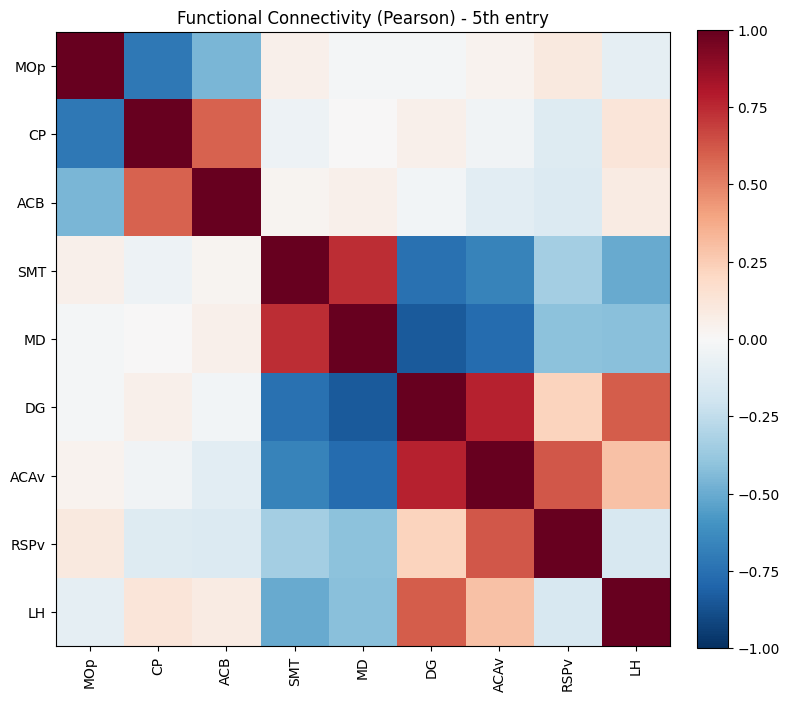

In [6]:
# Calculate Pearson FC matrix from fifth_lfp (structure: time x regions)
labels = list(region_labels_5)
lfp = np.array(fifth_lfp)  # ensure ndarray

# Ensure orientation: want shape (timepoints, n_regions)
if lfp.ndim != 2:
    raise ValueError(f"Expected 2D array for fifth_lfp, got shape {lfp.shape}")
# If rows correspond to regions, transpose
if lfp.shape[0] == len(labels) and lfp.shape[1] != len(labels):
    lfp = lfp.T
elif lfp.shape[1] != len(labels):
    raise ValueError(f"Mismatch between lfp shape {lfp.shape} and number of labels {len(labels)}")

# Pearson correlation across regions
fc = np.corrcoef(lfp, rowvar=False)
fc_df = pd.DataFrame(fc, index=labels, columns=labels)

print('FC matrix shape:', fc_df.shape)
display(fc_df)

# Plot heatmap
plt.figure(figsize=(8, 8))
im = plt.imshow(fc, cmap='RdBu_r', vmin=-1, vmax=1)
plt.title('Functional Connectivity (Pearson) - 5th entry')
plt.xticks(range(len(labels)), labels, rotation=90)
plt.yticks(range(len(labels)), labels)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
#plt.savefig('Fifth_lfp_FC_matrix.png', dpi=300)
plt.show()

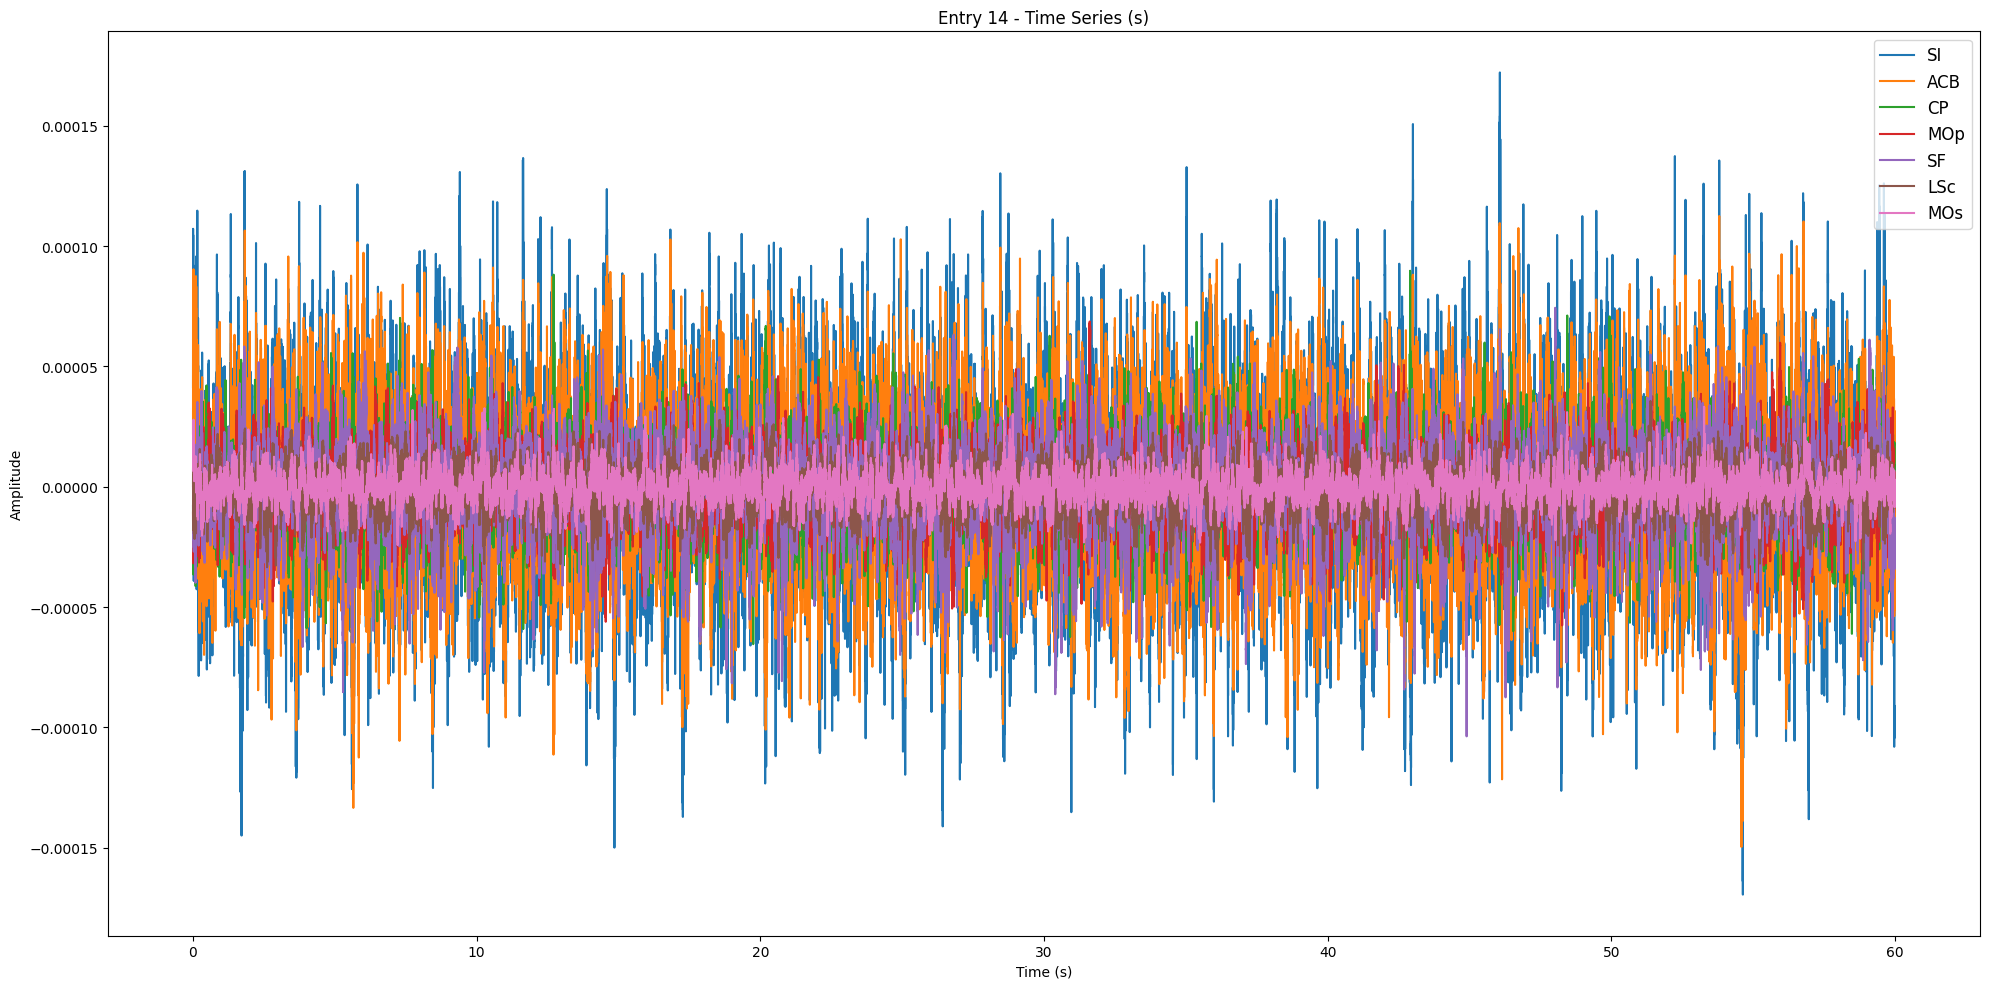

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [7]:
# Plot the time series for the fifth entry using its region labels
# Plot the time series for the fourteenth entry using its region labels
fourteenth_lfp = np.array(df['lfp_data'][13])
region_labels_14 = df['acronym'][13] if isinstance(df['acronym'][13], (list, tuple, np.ndarray)) else [df['acronym'][13]]

#plot_lfp_seconds(fourteenth_lfp, region_labels=region_labels_14, sfreq=2500, title='Entry 14 - Time Series (s)', save_name='Fourteenth_lfp_time_series.png')
plot_lfp_seconds(fourteenth_lfp, region_labels=region_labels_14, sfreq=2500, title='Entry 14 - Time Series (s)')

FC matrix shape: (7, 7)


,SI,ACB,CP,MOp,SF,LSc,MOs
SI,1.000000,0.643211,-0.691732,-0.020588,0.169771,0.028465,-0.149042
ACB,0.643211,1.000000,-0.772065,-0.086447,0.190375,0.082153,-0.101493
CP,-0.691732,-0.772065,1.000000,0.053637,-0.185228,-0.054720,0.124596
MOp,-0.020588,-0.086447,0.053637,1.000000,-0.400588,-0.657981,-0.287579
SF,0.169771,0.190375,-0.185228,-0.400588,1.000000,0.484454,-0.515757
LSc,0.028465,0.082153,-0.054720,-0.657981,0.484454,1.000000,0.028800
MOs,-0.149042,-0.101493,0.124596,-0.287579,-0.515757,0.028800,1.000000


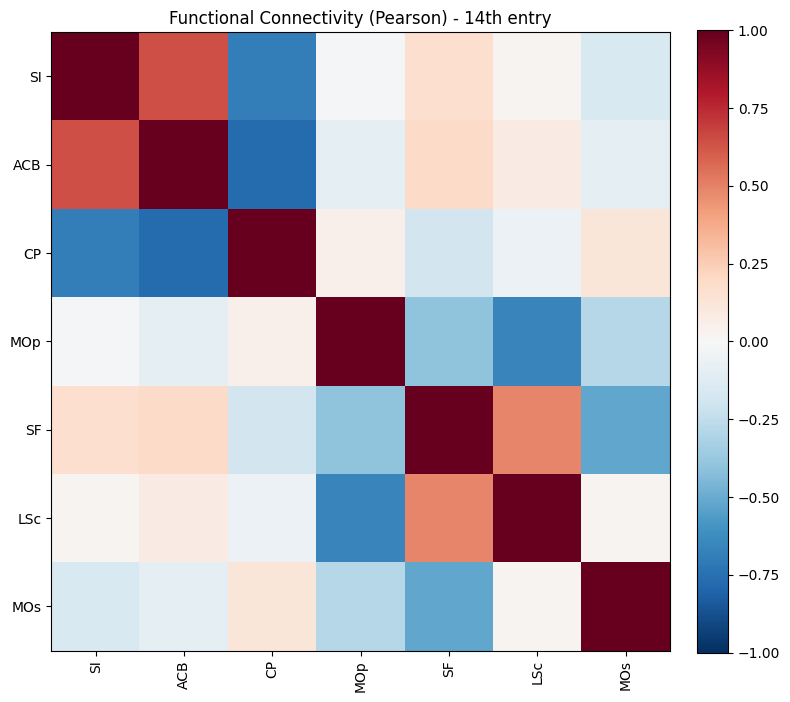

In [8]:
# Calculate Pearson FC matrix from fifth_lfp (structure: time x regions)
labels_14 = list(region_labels_14)
lfp_fourteenth = np.array(fourteenth_lfp)  # ensure ndarray

# Pearson correlation across regions
fc = np.corrcoef(lfp_fourteenth, rowvar=False)
fc_df = pd.DataFrame(fc, index=labels_14, columns=labels_14)

print('FC matrix shape:', fc_df.shape)
display(fc_df)

# Plot heatmap
plt.figure(figsize=(8, 8))
im = plt.imshow(fc, cmap='RdBu_r', vmin=-1, vmax=1)
plt.title('Functional Connectivity (Pearson) - 14th entry')
plt.xticks(range(len(labels_14)), labels_14, rotation=90)
plt.yticks(range(len(labels_14)), labels_14)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
#plt.savefig('Fourteenth_lfp_FC_matrix.png', dpi=300)
plt.show()

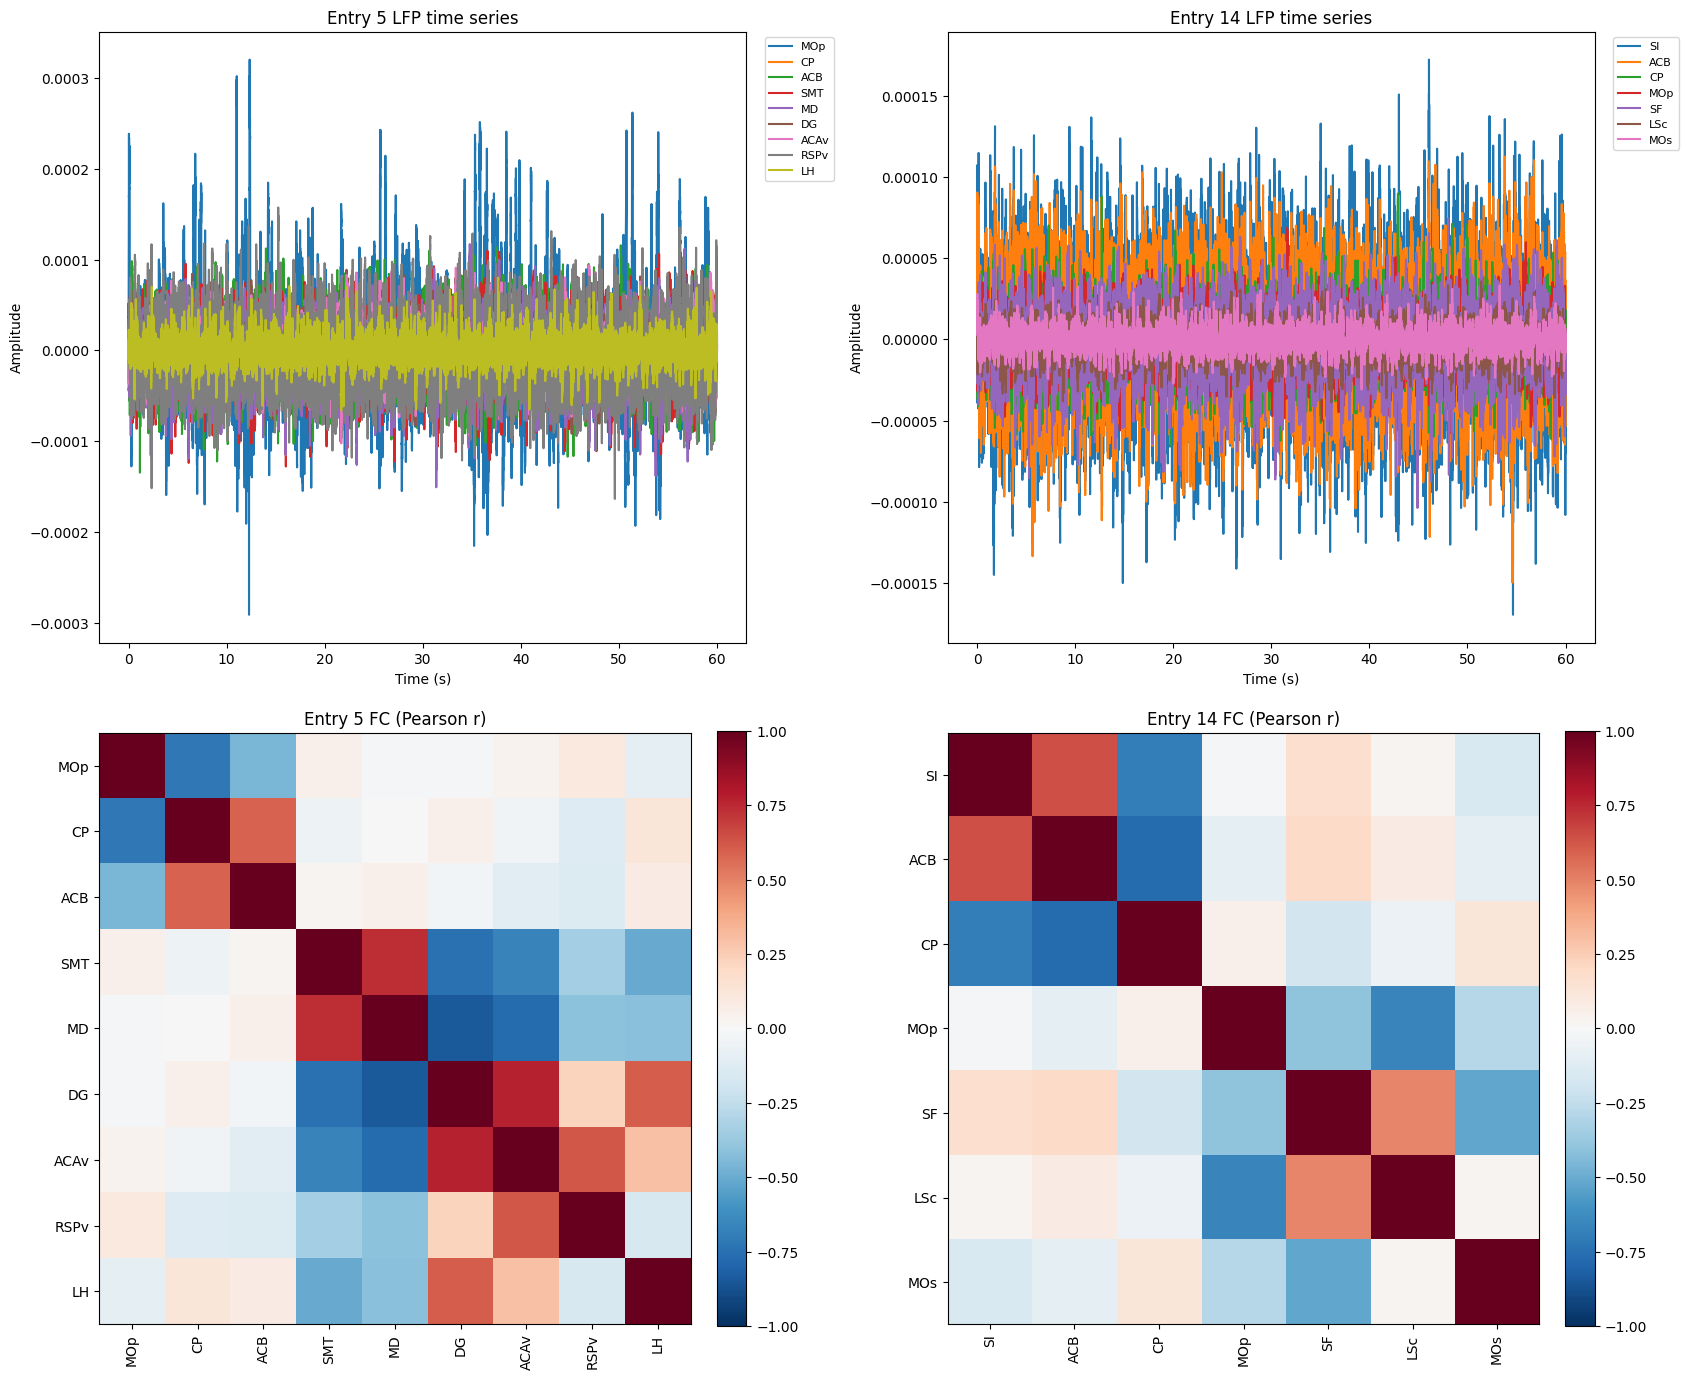

In [9]:
# 2x2 grid: Entry 5 & 14 time series (top) and their FC matrices (bottom)
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Ensure dataframe is loaded
try:
    df
except NameError:
    with open('dataframe_lfp.pkl', 'rb') as f:
        df = pickle.load(f)

sfreq = 2500  # Hz


def ensure_time_by_channels(lfp, labels):
    """Return (time x channels) array and labels list from possibly differently-shaped input."""
    lfp = np.array(lfp)
    if not isinstance(labels, (list, tuple, np.ndarray)):
        labels = [labels]
    if lfp.ndim == 1:
        lfp = lfp[:, None]
    nlab = len(labels)
    # If rows correspond to channels, transpose to (time x channels)
    if lfp.shape[0] == nlab and lfp.shape[1] != nlab:
        lfp = lfp.T
    # If columns correspond to channels, assume already (time x channels)
    elif lfp.shape[1] == nlab and lfp.shape[0] != nlab:
        pass
    # Heuristic fallback: if rows > cols, assume (channels x time)
    elif lfp.shape[0] > lfp.shape[1]:
        lfp = lfp.T
    return lfp, list(labels)


def get_entry(idx):
    lfp = df['lfp_data'][idx]
    labels = df['acronym'][idx] if isinstance(df['acronym'][idx], (list, tuple, np.ndarray)) else [df['acronym'][idx]]
    lfp_ts, labels = ensure_time_by_channels(lfp, labels)
    return lfp_ts, labels


# Zero-based indices for 5th and 14th entries
idx5 = 4
idx14 = 13

lfp5, labels5 = get_entry(idx5)
lfp14, labels14 = get_entry(idx14)

# Compute Pearson FC matrices (channels x channels)
fc5 = np.corrcoef(lfp5, rowvar=False)
fc14 = np.corrcoef(lfp14, rowvar=False)

# Create the 2x2 grid plot
fig, axes = plt.subplots(2, 2, figsize=(20, 14))

# Top-left: 5th entry time series
t5 = np.arange(lfp5.shape[0]) / float(sfreq)
for ch in range(lfp5.shape[1]):
    axes[0, 0].plot(t5, lfp5[:, ch], label=str(labels5[ch]))
axes[0, 0].set_title('Entry 5 LFP time series')
axes[0, 0].set_xlabel('Time (s)')
axes[0, 0].set_ylabel('Amplitude')
axes[0, 0].legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=8)

# Top-right: 14th entry time series
t14 = np.arange(lfp14.shape[0]) / float(sfreq)
for ch in range(lfp14.shape[1]):
    axes[0, 1].plot(t14, lfp14[:, ch], label=str(labels14[ch]))
axes[0, 1].set_title('Entry 14 LFP time series')
axes[0, 1].set_xlabel('Time (s)')
axes[0, 1].set_ylabel('Amplitude')
axes[0, 1].legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=8)

# Bottom-left: 5th entry FC matrix
im1 = axes[1, 0].imshow(fc5, cmap='RdBu_r', vmin=-1, vmax=1)
axes[1, 0].set_title('Entry 5 FC (Pearson r)')
axes[1, 0].set_xticks(np.arange(len(labels5)))
axes[1, 0].set_yticks(np.arange(len(labels5)))
axes[1, 0].set_xticklabels(labels5, rotation=90)
axes[1, 0].set_yticklabels(labels5)
fig.colorbar(im1, ax=axes[1, 0], fraction=0.046, pad=0.04)

# Bottom-right: 14th entry FC matrix
im2 = axes[1, 1].imshow(fc14, cmap='RdBu_r', vmin=-1, vmax=1)
axes[1, 1].set_title('Entry 14 FC (Pearson r)')
axes[1, 1].set_xticks(np.arange(len(labels14)))
axes[1, 1].set_yticks(np.arange(len(labels14)))
axes[1, 1].set_xticklabels(labels14, rotation=90)
axes[1, 1].set_yticklabels(labels14)
fig.colorbar(im2, ax=axes[1, 1], fraction=0.046, pad=0.04)

plt.tight_layout(rect=[0, 0, 0.85, 1])
#plt.savefig('LFP_FC_5th_14th_entries_RETUNE.png', dpi=300, bbox_inches='tight')
plt.show()

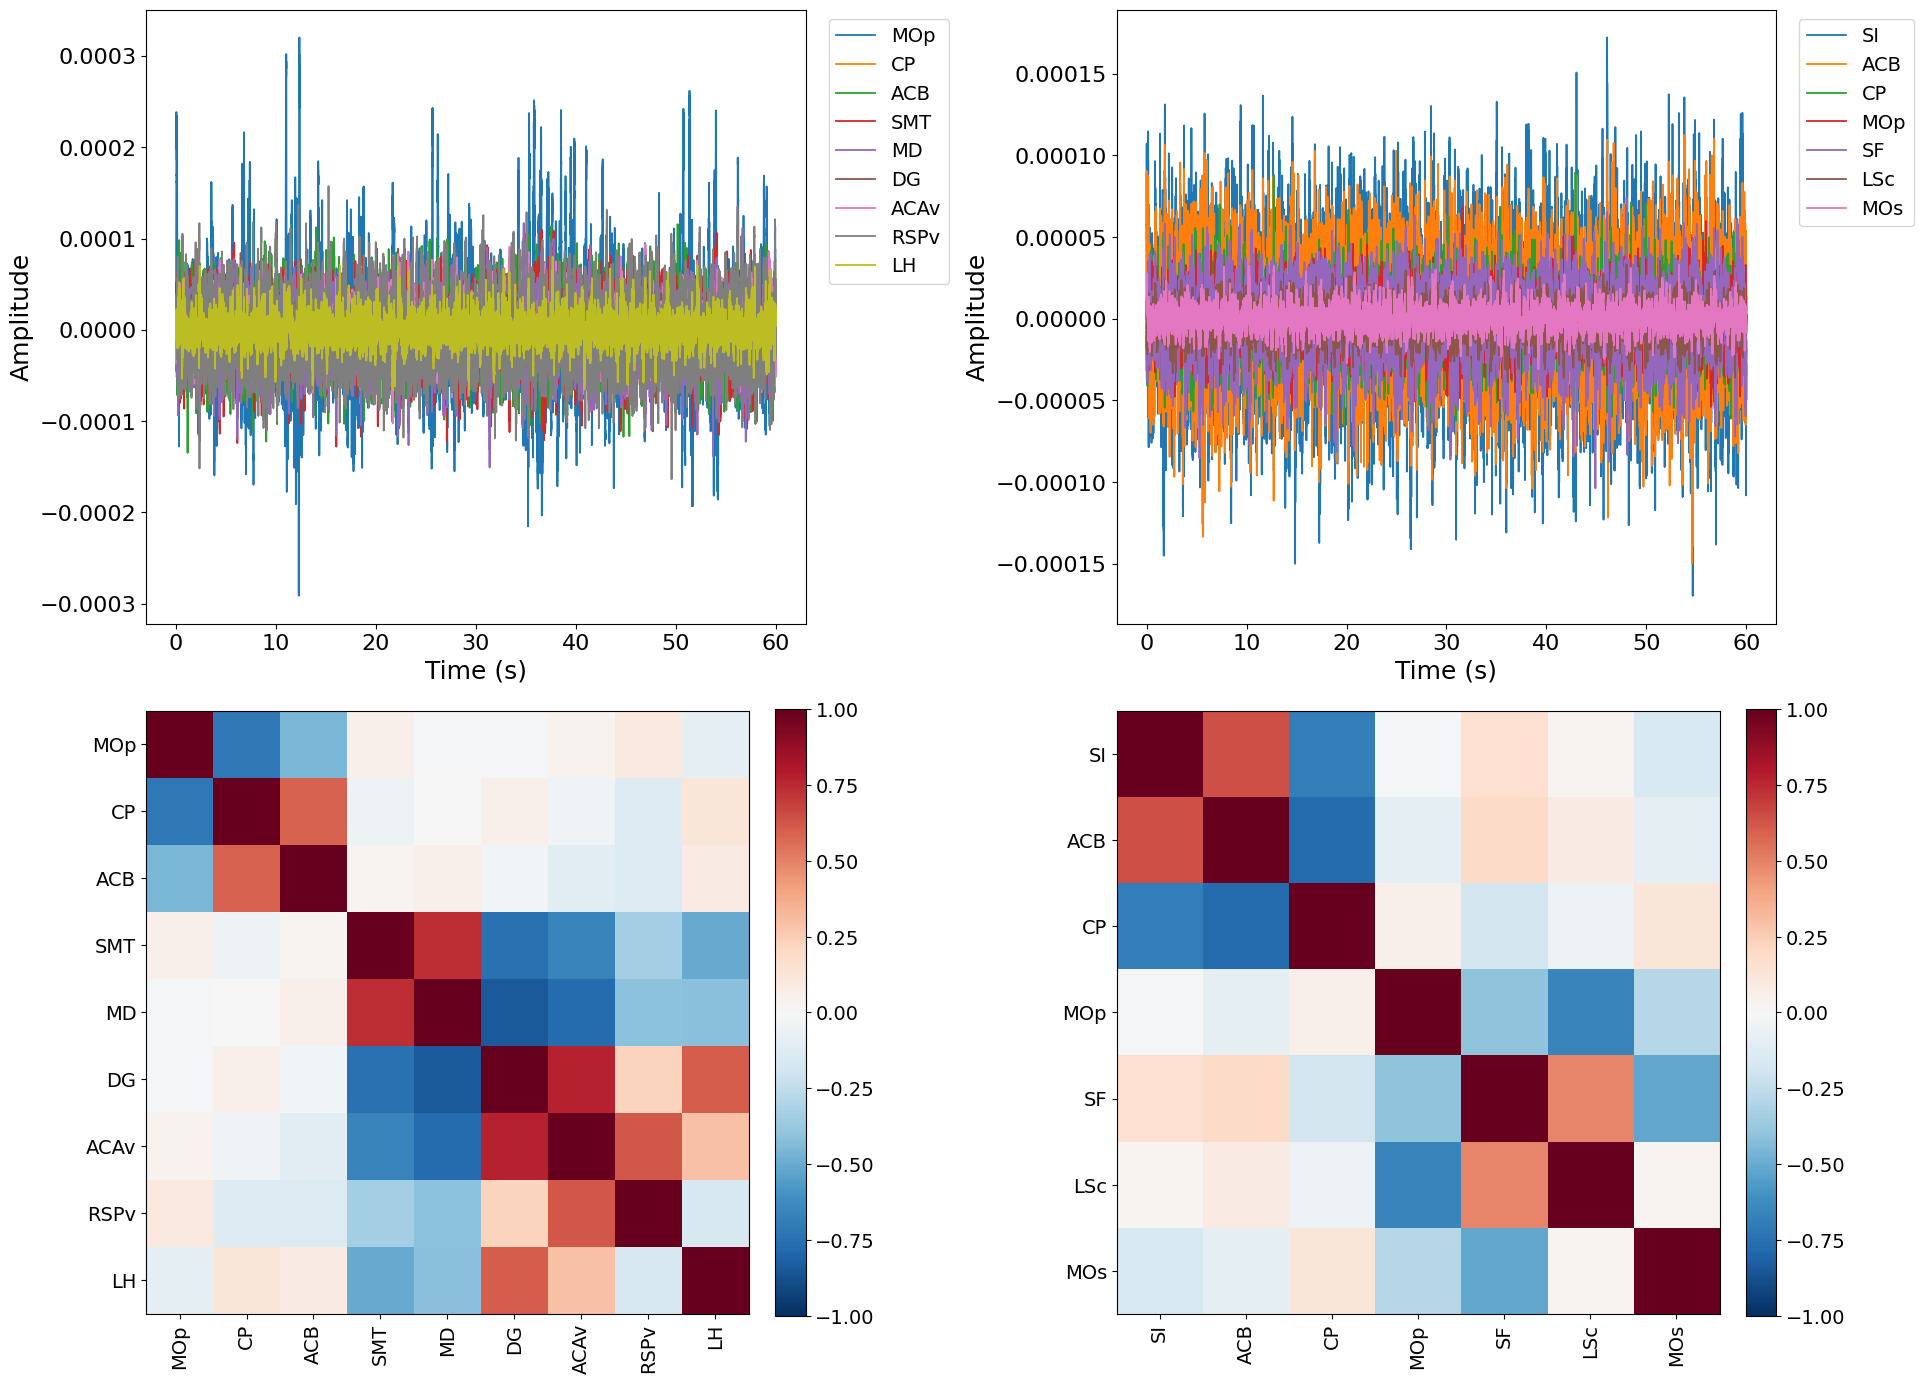

In [10]:
# 2x2 grid (no titles): Entry 5 & 14 time series (top) and their FC matrices (bottom)
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Ensure dataframe is loaded
try:
    df
except NameError:
    with open('dataframe_lfp.pkl', 'rb') as f:
        df = pickle.load(f)

sfreq = 2500  # Hz


def ensure_time_by_channels(lfp, labels):
    """Return (time x channels) array and labels list from possibly differently-shaped input."""
    lfp = np.array(lfp)
    if not isinstance(labels, (list, tuple, np.ndarray)):
        labels = [labels]
    if lfp.ndim == 1:
        lfp = lfp[:, None]
    nlab = len(labels)
    # If rows correspond to channels, transpose to (time x channels)
    if lfp.shape[0] == nlab and lfp.shape[1] != nlab:
        lfp = lfp.T
    # If columns correspond to channels, assume already (time x channels)
    elif lfp.shape[1] == nlab and lfp.shape[0] != nlab:
        pass
    # Heuristic fallback: if rows > cols, assume (channels x time)
    elif lfp.shape[0] > lfp.shape[1]:
        lfp = lfp.T
    return lfp, list(labels)


def get_entry(idx):
    lfp = df['lfp_data'][idx]
    labels = df['acronym'][idx] if isinstance(df['acronym'][idx], (list, tuple, np.ndarray)) else [df['acronym'][idx]]
    lfp_ts, labels = ensure_time_by_channels(lfp, labels)
    return lfp_ts, labels


# Zero-based indices for 5th and 14th entries
idx5 = 4
idx14 = 13

lfp5, labels5 = get_entry(idx5)
lfp14, labels14 = get_entry(idx14)

# Compute Pearson FC matrices (channels x channels)
fc5 = np.corrcoef(lfp5, rowvar=False)
fc14 = np.corrcoef(lfp14, rowvar=False)

# Create the 2x2 grid plot
fig, axes = plt.subplots(2, 2, figsize=(22, 14))

# Top-left: 5th entry time series
t5 = np.arange(lfp5.shape[0]) / float(sfreq)
for ch in range(lfp5.shape[1]):
    axes[0, 0].plot(t5, lfp5[:, ch], label=str(labels5[ch]), linewidth=1.3)
axes[0, 0].set_xlabel('Time (s)', fontsize=18)
axes[0, 0].set_ylabel('Amplitude', fontsize=18)
axes[0, 0].tick_params(axis='both', which='major', labelsize=16)
axes[0, 0].legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=14)

# Top-right: 14th entry time series
t14 = np.arange(lfp14.shape[0]) / float(sfreq)
for ch in range(lfp14.shape[1]):
    axes[0, 1].plot(t14, lfp14[:, ch], label=str(labels14[ch]), linewidth=1.3)
axes[0, 1].set_xlabel('Time (s)', fontsize=18)
axes[0, 1].set_ylabel('Amplitude', fontsize=18)
axes[0, 1].tick_params(axis='both', which='major', labelsize=16)
axes[0, 1].legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=14)

# Bottom-left: 5th entry FC matrix
im1 = axes[1, 0].imshow(fc5, cmap='RdBu_r', vmin=-1, vmax=1)
axes[1, 0].set_xticks(np.arange(len(labels5)))
axes[1, 0].set_yticks(np.arange(len(labels5)))
axes[1, 0].set_xticklabels(labels5, rotation=90, fontsize=14)
axes[1, 0].set_yticklabels(labels5, fontsize=14)
axes[1, 0].tick_params(axis='both', which='major', labelsize=14)
cbar1 = fig.colorbar(im1, ax=axes[1, 0], fraction=0.046, pad=0.04)
cbar1.ax.tick_params(labelsize=14)

# Bottom-right: 14th entry FC matrix
im2 = axes[1, 1].imshow(fc14, cmap='RdBu_r', vmin=-1, vmax=1)
axes[1, 1].set_xticks(np.arange(len(labels14)))
axes[1, 1].set_yticks(np.arange(len(labels14)))
axes[1, 1].set_xticklabels(labels14, rotation=90, fontsize=14)
axes[1, 1].set_yticklabels(labels14, fontsize=14)
axes[1, 1].tick_params(axis='both', which='major', labelsize=14)
cbar2 = fig.colorbar(im2, ax=axes[1, 1], fraction=0.046, pad=0.04)
cbar2.ax.tick_params(labelsize=14)

plt.tight_layout(rect=[0, 0, 0.88, 1])
# Optional save:
#plt.savefig('RETUNE_Poster_plots.png', dpi=300, bbox_inches='tight')
plt.show()

# STzyling Guide

In [11]:
# Apply the specified styling
plt.style.use('ggplot')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.rcParams.update({
    'font.family': 'Arial',
    'axes.facecolor': 'white',
    'axes.grid': False,
    'axes.spines.bottom': True,
    'axes.spines.left': True,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.edgecolor': colors[3],
    'grid.color': '#d4d4d4',
    'axes.titlesize': 'medium',
    'axes.labelsize': 'large',
    'xtick.labelsize': 'large',
    'ytick.labelsize': 'large',
    'legend.fontsize': 'large',
    'axes.axisbelow': False
})
cm = 1 / 2.54  # Conversion factor for cm to inches


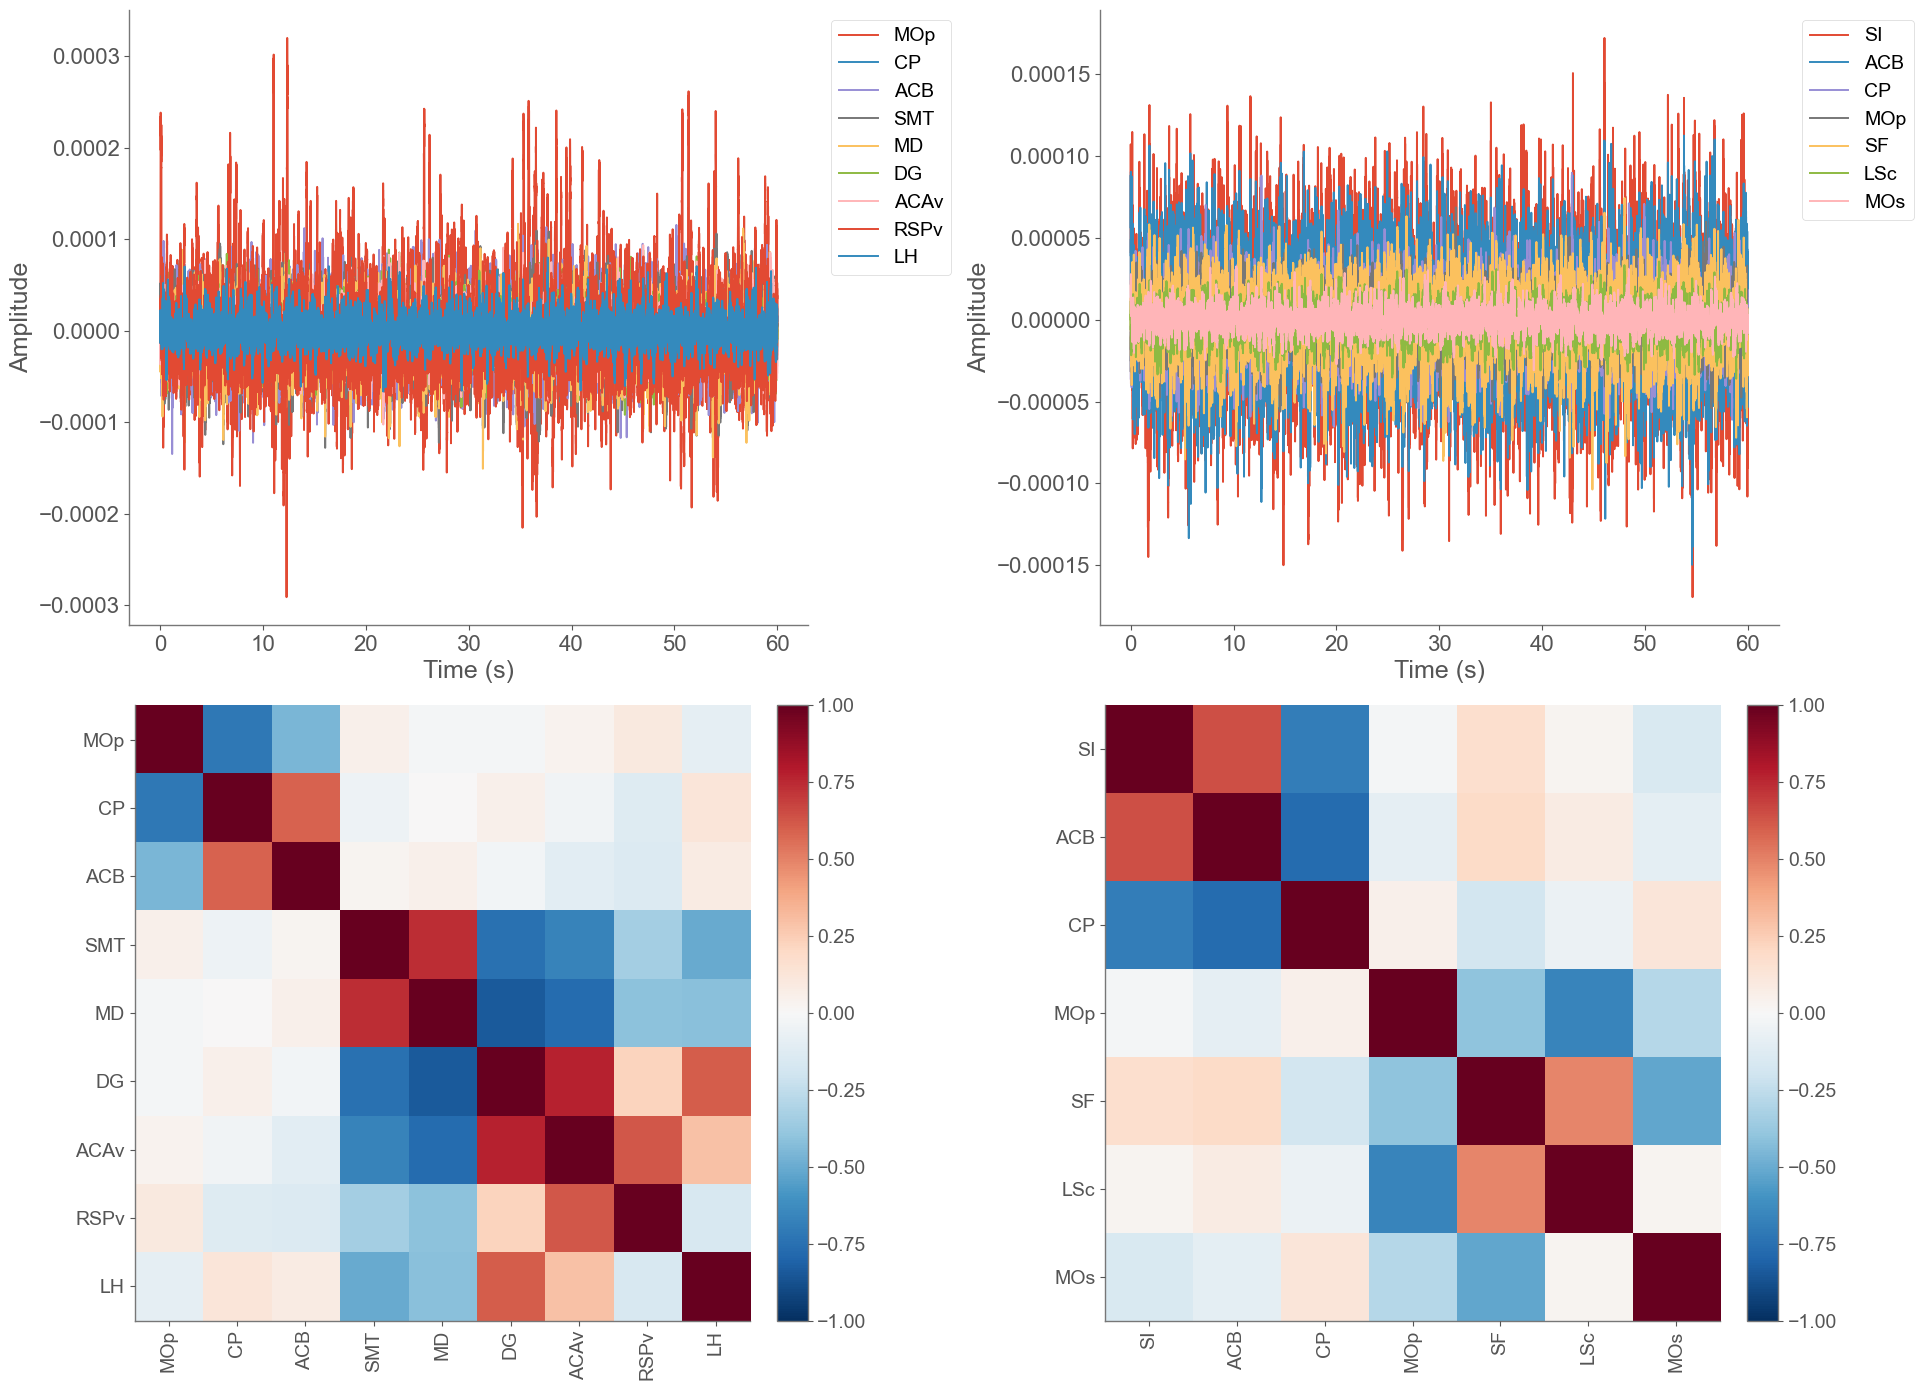

In [ ]:
# Apply the specified styling and re-plot 2x2 subplots (no titles)
import matplotlib.pyplot as plt

# Apply the specified styling
plt.style.use('ggplot')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.rcParams.update({
    'font.family': 'Arial',
    'axes.facecolor': 'white',
    'axes.grid': False,
    'axes.spines.bottom': True,
    'axes.spines.left': True,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.edgecolor': colors[3],
    'grid.color': '#d4d4d4',
    'axes.titlesize': 'medium',
    'axes.labelsize': 'large',
    'xtick.labelsize': 'large',
    'ytick.labelsize': 'large',
    'legend.fontsize': 'large',
    'axes.axisbelow': False
})
cm = 1 / 2.54  # Conversion factor for cm to inches

# Re-plot the 2x2 grid using the same data selections (5th and 14th entries)
import numpy as np
import pickle

# Ensure dataframe is loaded
try:
    df
except NameError:
    with open('dataframe_lfp.pkl', 'rb') as f:
        df = pickle.load(f)

sfreq = 2500  # Hz


def ensure_time_by_channels(lfp, labels):
    """Return (time x channels) array and labels list from possibly differently-shaped input."""
    lfp = np.array(lfp)
    if not isinstance(labels, (list, tuple, np.ndarray)):
        labels = [labels]
    if lfp.ndim == 1:
        lfp = lfp[:, None]
    nlab = len(labels)
    # If rows correspond to channels, transpose to (time x channels)
    if lfp.shape[0] == nlab and lfp.shape[1] != nlab:
        lfp = lfp.T
    # If columns correspond to channels, assume already (time x channels)
    elif lfp.shape[1] == nlab and lfp.shape[0] != nlab:
        pass
    # Heuristic fallback: if rows > cols, assume (channels x time)
    elif lfp.shape[0] > lfp.shape[1]:
        lfp = lfp.T
    return lfp, list(labels)


def get_entry(idx):
    lfp = df['lfp_data'][idx]
    labels = df['acronym'][idx] if isinstance(df['acronym'][idx], (list, tuple, np.ndarray)) else [df['acronym'][idx]]
    lfp_ts, labels = ensure_time_by_channels(lfp, labels)
    return lfp_ts, labels


# Zero-based indices for 5th and 14th entries
idx5 = 4
idx14 = 13

lfp5, labels5 = get_entry(idx5)
lfp14, labels14 = get_entry(idx14)

# Compute Pearson FC matrices (channels x channels)
fc5 = np.corrcoef(lfp5, rowvar=False)
fc14 = np.corrcoef(lfp14, rowvar=False)

# Create the 2x2 grid plot (no titles, larger fonts per your request)
fig, axes = plt.subplots(2, 2, figsize=(22, 14))

# Top-left: 5th entry time series
t5 = np.arange(lfp5.shape[0]) / float(sfreq)
for ch in range(lfp5.shape[1]):
    axes[0, 0].plot(t5, lfp5[:, ch], label=str(labels5[ch]), linewidth=1.4)
axes[0, 0].set_xlabel('Time (s)', fontsize=18)
axes[0, 0].set_ylabel('Amplitude', fontsize=18)
axes[0, 0].tick_params(axis='both', which='major', labelsize=16)
axes[0, 0].legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=14)

# Top-right: 14th entry time series
t14 = np.arange(lfp14.shape[0]) / float(sfreq)
for ch in range(lfp14.shape[1]):
    axes[0, 1].plot(t14, lfp14[:, ch], label=str(labels14[ch]), linewidth=1.4)
axes[0, 1].set_xlabel('Time (s)', fontsize=18)
axes[0, 1].set_ylabel('Amplitude', fontsize=18)
axes[0, 1].tick_params(axis='both', which='major', labelsize=16)
axes[0, 1].legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=14)

# Bottom-left: 5th entry FC matrix
im1 = axes[1, 0].imshow(fc5, cmap='RdBu_r', vmin=-1, vmax=1)
axes[1, 0].set_xticks(np.arange(len(labels5)))
axes[1, 0].set_yticks(np.arange(len(labels5)))
axes[1, 0].set_xticklabels(labels5, rotation=90, fontsize=14)
axes[1, 0].set_yticklabels(labels5, fontsize=14)
axes[1, 0].tick_params(axis='both', which='major', labelsize=14)
cbar1 = fig.colorbar(im1, ax=axes[1, 0], fraction=0.046, pad=0.04)
cbar1.ax.tick_params(labelsize=14)

# Bottom-right: 14th entry FC matrix
im2 = axes[1, 1].imshow(fc14, cmap='RdBu_r', vmin=-1, vmax=1)
axes[1, 1].set_xticks(np.arange(len(labels14)))
axes[1, 1].set_yticks(np.arange(len(labels14)))
axes[1, 1].set_xticklabels(labels14, rotation=90, fontsize=14)
axes[1, 1].set_yticklabels(labels14, fontsize=14)
axes[1, 1].tick_params(axis='both', which='major', labelsize=14)
cbar2 = fig.colorbar(im2, ax=axes[1, 1], fraction=0.046, pad=0.04)
cbar2.ax.tick_params(labelsize=14)

plt.tight_layout(rect=[0, 0, 0.88, 1])
# Optional save
#plt.savefig('RETUNE_Poster_plots_styled.png', dpi=300, bbox_inches='tight')
plt.show()